# Optimisation of a Neocortical Layer 5 Pyramidal Cell

This notebook shows you how to optimise the maximal conductance of Neocortical Layer 5 Pyramidal Cell as used in Markram et al. 2015.

Author of this script: Werner Van Geit @ Blue Brain Project

Choice of parameters, protocols and other settings was done by Etay Hay @ HUJI

What's described here is a more advanced use of BluePyOpt. We suggest to first go through the introductary example here: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/simplecell/simplecell.ipynb

**If you use the methods in this notebook, we ask you to cite the following publications when publishing your research:**

Van Geit, W., M. Gevaert, G. Chindemi, C. Rössert, J.-D. Courcol, E. Muller, F. Schürmann, I. Segev, and H. Markram (2016, March). BluePyOpt: Leveraging open source software and cloud infrastructure to optimise model parameters in neuroscience. ArXiv e-prints.
http://arxiv.org/abs/1603.00500

Markram, H., E. Muller, S. Ramaswamy, M. W. Reimann, M. Abdellah, C. A. Sanchez, A. Ailamaki, L. Alonso-Nanclares, N. Antille, S. Arsever, et al. (2015). Reconstruction and simulation of neocortical microcircuitry. Cell 163(2), 456–492.
http://www.cell.com/abstract/S0092-8674%2815%2901191-5

Some of the modules loaded in this script are located in the L5PC example folder: https://github.com/BlueBrain/BluePyOpt/tree/master/examples/l5pc 

We first load the bluepyopt python module, the ephys submodule and some helper functionality

In [1]:
%load_ext autoreload
%autoreload

!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

%matplotlib notebook
import matplotlib.pyplot as plt

/home/courcol/DEV/github/BluePyOpt/examples/l5pc
mechanisms/CaDynamics_E2.mod mechanisms/Ca_HVA.mod mechanisms/Ca_LVAst.mod mechanisms/Ih.mod mechanisms/Im.mod mechanisms/K_Pst.mod mechanisms/K_Tst.mod mechanisms/NaTa_t.mod mechanisms/NaTs2_t.mod mechanisms/Nap_Et2.mod mechanisms/ProbAMPANMDA_EMS.mod mechanisms/ProbGABAAB_EMS.mod mechanisms/SK_E2.mod mechanisms/SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod SK_E2.mod SKv3_1.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath 

/home/courcol/DEV/github/BluePyOpt/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Enable the code below to enable debug level logging

In [2]:
# import logging                                                                      
# logging.basicConfig()                                                               
# logger = logging.getLogger()                                                        
# logger.setLevel(logging.DEBUG)   

## Model description

### Morphology

We're using a complex reconstructed morphology of an L5PC cell. Let's visualise this with the BlueBrain NeuroM software:

/home/courcol/DEV/github/BluePyOpt/venv/local/lib/python2.7/site-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/home/courcol/DEV/github/BluePyOpt/venv/local/lib/python2.7/site-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
Requirement already up-to-date: neurom in /home/courcol/DEV/github/Bl

/home/courcol/DEV/github/BluePyOpt/venv/local/lib/python2.7/site-packages/neurom/utils.py:81: DeprecationWarning: Module neurom.point_neurite.segments is deprecated. 
  _warn_deprecated('Module %s is deprecated. %s' % (mod_name, msg))
/home/courcol/DEV/github/BluePyOpt/venv/local/lib/python2.7/site-packages/neurom/io/neurolucida.py:251: UserWarning: This is an experimental reader. There are no guarantees regarding ability to parse Neurolucida .asc files or correctness of output.
  warnings.warn(msg)
No handlers could be found for logger "neurom.io.neurolucida"


<IPython.core.display.Javascript object>


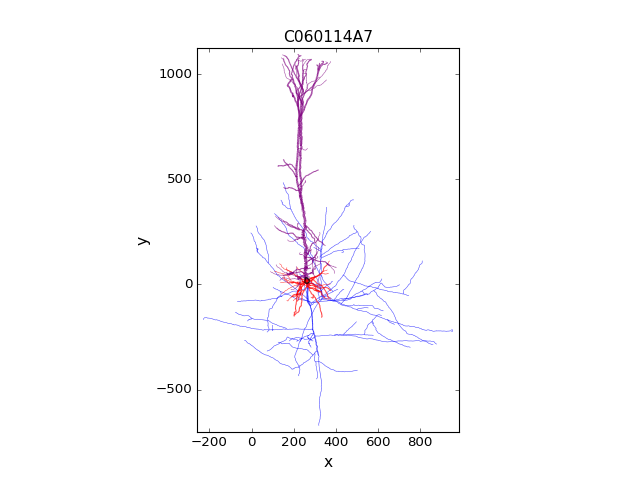

In [3]:
!pip install neurom --upgrade
import neurom.viewer
neurom.viewer.draw(neurom.load_neuron('morphology/C060114A7.asc'));

To load the morphology we create a NrnFileMorphology object. We set 'do_replace_axon' to True to replace the axon with a AIS.

In [4]:
morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
print str(morphology)

morphology/C060114A7.asc


### Parameters

Since we have many parameters in this model, they are stored in a json file: https://github.com/BlueBrain/BluePyOpt/blob/master/examples/l5pc/config/parameters.json

In [5]:
import json
param_configs = json.load(open('config/parameters.json'))
print [param_config['param_name'] for param_config in param_configs]

[u'g_pas', u'e_pas', u'cm', u'Ra', u'v_init', u'celsius', u'ena', u'ek', u'cm', u'ena', u'ek', u'cm', u'ena', u'ek', u'gIhbar_Ih', u'gNaTs2_tbar_NaTs2_t', u'gSKv3_1bar_SKv3_1', u'gImbar_Im', u'gIhbar_Ih', u'gNaTa_tbar_NaTa_t', u'gNap_Et2bar_Nap_Et2', u'gK_Pstbar_K_Pst', u'gK_Tstbar_K_Tst', u'gSK_E2bar_SK_E2', u'gSKv3_1bar_SKv3_1', u'gCa_HVAbar_Ca_HVA', u'gCa_LVAstbar_Ca_LVAst', u'gamma_CaDynamics_E2', u'decay_CaDynamics_E2', u'gNaTs2_tbar_NaTs2_t', u'gSKv3_1bar_SKv3_1', u'gSK_E2bar_SK_E2', u'gCa_HVAbar_Ca_HVA', u'gCa_LVAstbar_Ca_LVAst', u'gamma_CaDynamics_E2', u'decay_CaDynamics_E2', u'gIhbar_Ih']


The directory that contains this notebook has a module that will load all the parameters in BluePyOpt Parameter objects

In [6]:
import l5pc_model
parameters = l5pc_model.define_parameters()
print '\n'.join('%s' % param for param in parameters)

g_pas.all: ['all'] g_pas = 3e-05
e_pas.all: ['all'] e_pas = -75
cm.all: ['all'] cm = 1
Ra.all: ['all'] Ra = 100
v_init: v_init = -65
celsius: celsius = 34
ena.apical: ['apical'] ena = 50
ek.apical: ['apical'] ek = -85
cm.apical: ['apical'] cm = 2
ena.somatic: ['somatic'] ena = 50
ek.somatic: ['somatic'] ek = -85
cm.basal: ['basal'] cm = 2
ena.axonal: ['axonal'] ena = 50
ek.axonal: ['axonal'] ek = -85
gIhbar_Ih.basal: ['basal'] gIhbar_Ih = 8e-05
gNaTs2_tbar_NaTs2_t.apical: ['apical'] gNaTs2_tbar_NaTs2_t = [0, 0.04]
gSKv3_1bar_SKv3_1.apical: ['apical'] gSKv3_1bar_SKv3_1 = [0, 0.04]
gImbar_Im.apical: ['apical'] gImbar_Im = [0, 0.001]
gIhbar_Ih.apical: ['apical'] gIhbar_Ih = 8e-05
gNaTa_tbar_NaTa_t.axonal: ['axonal'] gNaTa_tbar_NaTa_t = [0, 4]
gNap_Et2bar_Nap_Et2.axonal: ['axonal'] gNap_Et2bar_Nap_Et2 = [0, 4]
gK_Pstbar_K_Pst.axonal: ['axonal'] gK_Pstbar_K_Pst = [0, 1]
gK_Tstbar_K_Tst.axonal: ['axonal'] gK_Tstbar_K_Tst = [0, 0.1]
gSK_E2bar_SK_E2.axonal: ['axonal'] gSK_E2bar_SK_E2 = [0, 0.1

As you can see there are two types of parameters, parameters with a fixed value and parameters with bounds. The latter will be optimised by the algorithm.

### Mechanism

We also need to add all the necessary mechanisms, like ion channels to the model. 
The configuration of the mechanisms is also stored in a json file, and can be loaded in a similar way.

In [7]:
mechanisms = l5pc_model.define_mechanisms()
print '\n'.join('%s' % mech for mech in mechanisms)

Ih.basal: Ih at ['basal']
pas.all: pas at ['all']
NaTs2_t.somatic: NaTs2_t at ['somatic']
SKv3_1.somatic: SKv3_1 at ['somatic']
SK_E2.somatic: SK_E2 at ['somatic']
CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
Ca_HVA.somatic: Ca_HVA at ['somatic']
Ca_LVAst.somatic: Ca_LVAst at ['somatic']
Ih.somatic: Ih at ['somatic']
Ih.apical: Ih at ['apical']
Im.apical: Im at ['apical']
SKv3_1.apical: SKv3_1 at ['apical']
NaTs2_t.apical: NaTs2_t at ['apical']
Ca_LVAst.axonal: Ca_LVAst at ['axonal']
Ca_HVA.axonal: Ca_HVA at ['axonal']
CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
SKv3_1.axonal: SKv3_1 at ['axonal']
SK_E2.axonal: SK_E2 at ['axonal']
K_Tst.axonal: K_Tst at ['axonal']
K_Pst.axonal: K_Pst at ['axonal']
Nap_Et2.axonal: Nap_Et2 at ['axonal']
NaTa_t.axonal: NaTa_t at ['axonal']


# Cell model

With the morphology, mechanisms and parameters we can build the cell model

In [8]:
l5pc_cell = ephys.models.CellModel('l5pc', morph=morphology, mechs=mechanisms, params=parameters)
print l5pc_cell

l5pc:
  morphology:
    morphology/C060114A7.asc
  mechanisms:
    Ih.basal: Ih at ['basal']
    pas.all: pas at ['all']
    NaTs2_t.somatic: NaTs2_t at ['somatic']
    SKv3_1.somatic: SKv3_1 at ['somatic']
    SK_E2.somatic: SK_E2 at ['somatic']
    CaDynamics_E2.somatic: CaDynamics_E2 at ['somatic']
    Ca_HVA.somatic: Ca_HVA at ['somatic']
    Ca_LVAst.somatic: Ca_LVAst at ['somatic']
    Ih.somatic: Ih at ['somatic']
    Ih.apical: Ih at ['apical']
    Im.apical: Im at ['apical']
    SKv3_1.apical: SKv3_1 at ['apical']
    NaTs2_t.apical: NaTs2_t at ['apical']
    Ca_LVAst.axonal: Ca_LVAst at ['axonal']
    Ca_HVA.axonal: Ca_HVA at ['axonal']
    CaDynamics_E2.axonal: CaDynamics_E2 at ['axonal']
    SKv3_1.axonal: SKv3_1 at ['axonal']
    SK_E2.axonal: SK_E2 at ['axonal']
    K_Tst.axonal: K_Tst at ['axonal']
    K_Pst.axonal: K_Pst at ['axonal']
    Nap_Et2.axonal: Nap_Et2 at ['axonal']
    NaTa_t.axonal: NaTa_t at ['axonal']
  params:
    g_pas.all: ['all'] g_pas = 3e-05
    e_pa

For use in the cell evaluator later, we need to make a list of the name of the parameters we are going to optimise.
These are the parameters that are not frozen.

In [9]:
param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

## Protocols

Now that we have a cell model, we can apply protocols to it. The protocols are also stored in a json file.

In [10]:
proto_configs = json.load(open('config/protocols.json'))
print proto_configs

{u'Step1': {u'stimuli': [{u'delay': 700, u'amp': 0.458, u'duration': 2000, u'totduration': 3000}, {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}]}, u'Step3': {u'stimuli': [{u'delay': 700, u'amp': 0.95, u'duration': 2000, u'totduration': 3000}, {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}]}, u'Step2': {u'stimuli': [{u'delay': 700, u'amp': 0.562, u'duration': 2000, u'totduration': 3000}, {u'delay': 0, u'amp': -0.126, u'duration': 3000, u'totduration': 3000}]}, u'bAP': {u'stimuli': [{u'delay': 295, u'amp': 1.9, u'duration': 5, u'totduration': 600}], u'extra_recordings': [{u'var': u'v', u'somadistance': 660, u'type': u'somadistance', u'name': u'dend1', u'seclist_name': u'apical'}, {u'var': u'v', u'somadistance': 800, u'type': u'somadistance', u'name': u'dend2', u'seclist_name': u'apical'}]}}


And they can be automatically loaded

In [11]:
import l5pc_evaluator
fitness_protocols = l5pc_evaluator.define_protocols()
print '\n'.join('%s' % protocol for protocol in fitness_protocols.values())

bAP:
  stimuli:
    Square pulse amp 1.900000 delay 295.000000 duration 5.000000 totdur 600.000000 at somatic[0](0.5)
  recordings:
    bAP.soma.v: v at somatic[0](0.5)
    bAP.dend1.v: v at 660.000000 micron from soma in apical
    bAP.dend2.v: v at 800.000000 micron from soma in apical

Step3:
  stimuli:
    Square pulse amp 0.950000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step3.soma.v: v at somatic[0](0.5)

Step2:
  stimuli:
    Square pulse amp 0.562000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp -0.126000 delay 0.000000 duration 3000.000000 totdur 3000.000000 at somatic[0](0.5)
  recordings:
    Step2.soma.v: v at somatic[0](0.5)

Step1:
  stimuli:
    Square pulse amp 0.458000 delay 700.000000 duration 2000.000000 totdur 3000.000000 at somatic[0](0.5)
    Square pulse amp

## eFeatures

For every protocol we need to define which eFeatures will be used as objectives of the optimisation algorithm.

In [12]:
feature_configs = json.load(open('config/features.json'))
pp.pprint(feature_configs)

{ u'Step1': { u'soma': { u'AHP_depth_abs': [-60.3636, 2.3018],
                         u'AHP_depth_abs_slow': [-61.1513, 2.3385],
                         u'AHP_slow_time': [0.1599, 0.0483],
                         u'AP_height': [25.0141, 3.1463],
                         u'AP_width': [3.5312, 0.8592],
                         u'ISI_CV': [0.109, 0.1217],
                         u'adaptation_index2': [0.0047, 0.0514],
                         u'doublet_ISI': [62.75, 9.6667],
                         u'mean_frequency': [6, 1.2222],
                         u'time_to_first_spike': [27.25, 5.7222]}},
  u'Step2': { u'soma': { u'AHP_depth_abs': [-59.9055, 1.8329],
                         u'AHP_depth_abs_slow': [-60.2471, 1.8972],
                         u'AHP_slow_time': [0.1676, 0.0339],
                         u'AP_height': [27.1003, 3.1463],
                         u'AP_width': [2.7917, 0.7499],
                         u'ISI_CV': [0.0674, 0.075],
                         u'adaptat

In [13]:
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)
print fitness_calculator

objectives:
  ( AP_height for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 25.0141 and std 3.1463 and AP threshold override -20 )
  ( AHP_slow_time for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 0.1599 and std 0.0483 and AP threshold override -20 )
  ( ISI_CV for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 0.109 and std 0.1217 and AP threshold override -20 )
  ( doublet_ISI for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 62.75 and std 9.6667 and AP threshold override -20 )
  ( AHP_depth_abs_slow for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean -61.1513 and std 2.3385 and AP threshold override -20 )
  ( AP_width for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 3.5312 and std 0.8592 and AP threshold override -20 )
  ( time_to_first_spike for {'': u'Step1.soma.v'} with stim start 700 and end 2700, exp mean 27.25 and std 5.7222 and AP threshold override -20 )
  ( AHP_

## Simulator

We need to define which simulator we will use. In this case it will be Neuron, i.e. the NrnSimulator class

In [14]:
sim = ephys.simulators.NrnSimulator()

## Evaluator

With all the components defined above we can build a cell evaluator

In [15]:
evaluator = ephys.evaluators.CellEvaluator(                                          
        cell_model=l5pc_cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)  

This evaluator can be used to run the protocols. The original parameter values for the Markram et al. 2015 L5PC model are:

In [16]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}


Running the responses is as easy as passing the protocols and parameters to the evaluator. (The line below will take some time to execute)

In [17]:
release_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=release_params)

We can now plot all the responses

<IPython.core.display.Javascript object>


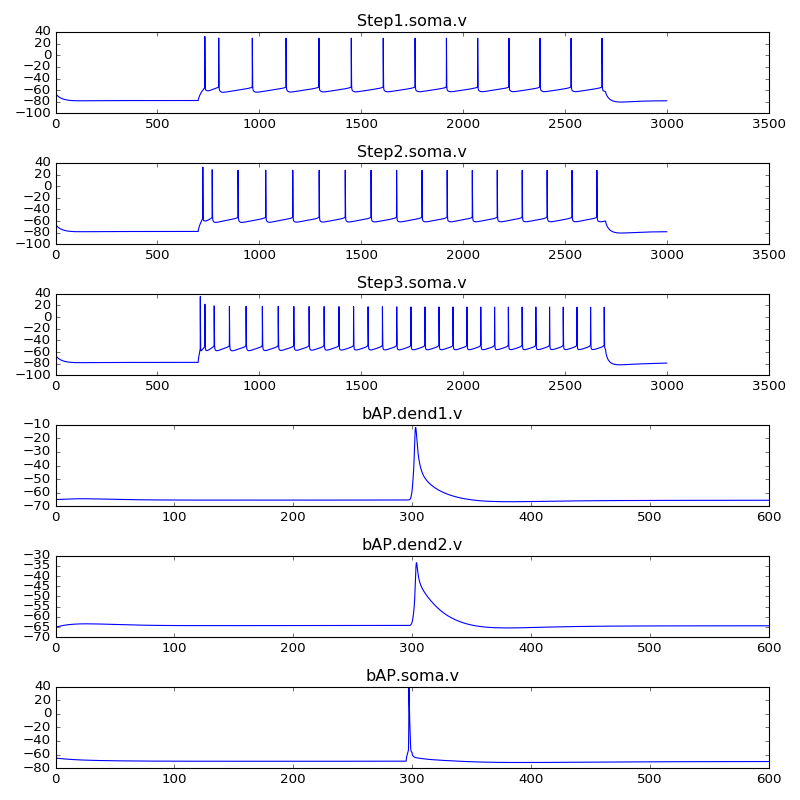

In [18]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()
plot_responses(release_responses)

Running an optimisation of the parameters now has become very easy. 
Of course running the L5PC optimisation will require quite some computing resources. 

To show a proof-of-concept, we will only run 2 generations, with 2 offspring individuals per generations.
If you want to run all full optimisation, you should run for 100 generations with an offspring size of 100 individuals. 

In [19]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=2) 
final_pop, halloffame, log, hist = opt.run(max_ngen=2, cp_filename='checkpoints/checkpoint.pkl')

/home/courcol/DEV/github/BluePyOpt/bluepyopt/deapext/tools/selIBEA.py:79: RuntimeWarning: invalid value encountered in divide
  box_ranges),


The first individual in the hall of fame will contain the best solution found.

In [20]:
print halloffame[0]

[0.001017834439738432, 0.021656498911739864, 0.0009391491627785106, 1.5248169507528497, 0.8663975885224535, 0.4221165755827173, 0.0029040787574867947, 0.022169166627303505, 0.8757751873011441, 0.0004958122413818507, 0.002330844502575726, 0.011927893806278723, 234.40541659093483, 0.4596034657377336, 0.28978161459048557, 0.0021489705265908877, 0.0008375779756625729, 0.005564543226524335, 0.03229357096515606, 202.18814057682334]


These are the raw parameter values. 
The evaluator object can convert this in a dictionary, so that we can see the parameter names corresponding to these values.

In [21]:
best_params = evaluator.param_dict(halloffame[0])
print pp.pprint(best_params)

{ u'decay_CaDynamics_E2.axonal': 234.40541659093483,
  u'decay_CaDynamics_E2.somatic': 202.18814057682334,
  u'gCa_HVAbar_Ca_HVA.axonal': 0.0004958122413818507,
  u'gCa_HVAbar_Ca_HVA.somatic': 0.0008375779756625729,
  u'gCa_LVAstbar_Ca_LVAst.axonal': 0.002330844502575726,
  u'gCa_LVAstbar_Ca_LVAst.somatic': 0.005564543226524335,
  u'gImbar_Im.apical': 0.0009391491627785106,
  u'gK_Pstbar_K_Pst.axonal': 0.4221165755827173,
  u'gK_Tstbar_K_Tst.axonal': 0.0029040787574867947,
  u'gNaTa_tbar_NaTa_t.axonal': 1.5248169507528497,
  u'gNaTs2_tbar_NaTs2_t.apical': 0.001017834439738432,
  u'gNaTs2_tbar_NaTs2_t.somatic': 0.4596034657377336,
  u'gNap_Et2bar_Nap_Et2.axonal': 0.8663975885224535,
  u'gSK_E2bar_SK_E2.axonal': 0.022169166627303505,
  u'gSK_E2bar_SK_E2.somatic': 0.0021489705265908877,
  u'gSKv3_1bar_SKv3_1.apical': 0.021656498911739864,
  u'gSKv3_1bar_SKv3_1.axonal': 0.8757751873011441,
  u'gSKv3_1bar_SKv3_1.somatic': 0.28978161459048557,
  u'gamma_CaDynamics_E2.axonal': 0.0119278938062

Then we can run the fitness protocols on the model with these parameter values

In [22]:
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

And then we can also plot these responses. 

When you ran the above optimisation with only 2 individuals and 2 generations, this 'best' model will of course be very low quality.

<IPython.core.display.Javascript object>


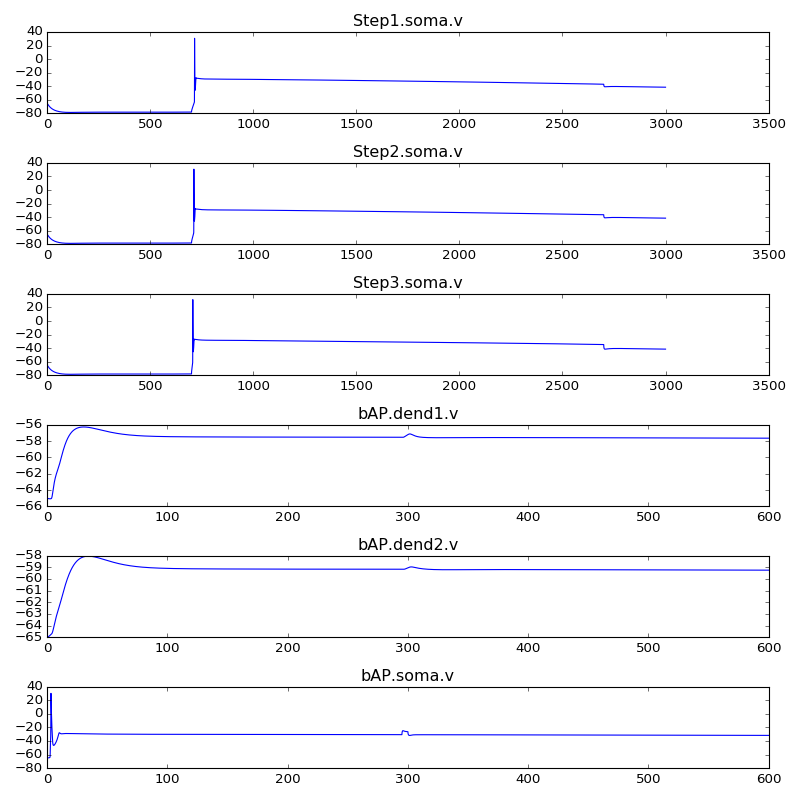

In [23]:
plot_responses(best_responses)